# Evaporation pattern

In [1]:
import cosima_cookbook as cc
from dask.distributed import Client

import xarray as xr
import matplotlib.pyplot as plt
import cmocean as cm
import numpy as np
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39917/status,
Dashboard: /proxy/39917/status,Workers: 4
Total threads: 4,Total memory: 18.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37173,Workers: 4
Dashboard: /proxy/39917/status,Total threads: 4
Started: Just now,Total memory: 18.00 GiB
Comm: tcp://127.0.0.1:35655,Total threads: 1
Dashboard: /proxy/44659/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:35035,


In [3]:
# CM2 database
session_CM2 = cc.database.create_session('/g/data/p73/archive/non-CMIP/ACCESS-CM2/CM2.db')
expt_CM2_025 = 'cj877'
expt_CM2_1   = 'bz687'

In [4]:
# OM2 database
session_OM2  = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
expt_OM2_025 = '025deg_jra55_ryf9091_bgc'#'025deg_jra55_ryf9091_gadi'
expt_OM2_1   = '1deg_jra55_ryf9091_gadi'

In [5]:
# Plotting info
ft_size = 16
plt.rcParams.update({'font.size': ft_size})
fig_path = '/g/data/x77/wgh581/Figures/Figures_ACCESS_CM2/'

Model evaporation

In [6]:
def get_evap_clim(expt, session, start_time, end_time, frequency='1 monthly'):
    
    evap = cc.querying.getvar(expt, 'evap', session, start_time=start_time, end_time=end_time, frequency='1 monthly')
    evap = evap.sel(time=slice(start_time, end_time))
    evap_clim = evap.groupby('time.month').mean('time')
    
    return evap_clim.compute()

In [ ]:
%%time
evap_CM2_025_clim = get_evap_clim(expt_CM2_025, session_CM2, start_time='0400-01-01', end_time='0499-12-31')

In [ ]:
evap_CM2_1_clim = get_evap_clim(expt_CM2_1, session_CM2, start_time='0400-01-01', end_time='0499-12-31')

In [9]:
# Output not available for *ryf_gadi, therefore using *ryf_bgc
evap_OM2_025_clim = get_evap_clim(expt_OM2_025, session_OM2, start_time='2000-01-01', end_time='2099-12-31')

In [ ]:
# Output not available for 2300-2399, but 2400-2499
evap_OM2_1_clim = get_evap_clim(expt_OM2_1, session_OM2, start_time='2400-01-01', end_time='2499-12-31')

Coordinate stuff

In [11]:
geolon_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolon_t
geolat_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolat_t

In [12]:
geolon_t_1 = xr.open_dataset('/g/data/ik11/grids/ocean_grid_10.nc').geolon_t
geolat_t_1 = xr.open_dataset('/g/data/ik11/grids/ocean_grid_10.nc').geolat_t

In [31]:
# evap_CM2_025_clim = evap_CM2_025_clim.assign_coords({'geolon_t': geolon_t, 'geolat_t': geolat_t})
# evap_OM2_025_clim = evap_OM2_025_clim.assign_coords({'geolon_t': geolon_t, 'geolat_t': geolat_t})
# evap_CM2_1_clim   = evap_CM2_1_clim.assign_coords({'geolon_t': geolon_t_1, 'geolat_t': geolat_t_1})
# evap_OM2_1_clim   = evap_OM2_1_clim.assign_coords({'geolon_t': geolon_t_1, 'geolat_t': geolat_t_1})

##### Convert evaporative mass flux to evaporation in mm per time

In [13]:
convert_flux_dirn = -1

evap_CM2_025_clim_mmd = evap_CM2_025_clim*(60*60*24)*convert_flux_dirn
evap_CM2_025_clim_mmd.attrs["units"] = "mm.day-1"
evap_OM2_025_clim_mmd = evap_OM2_025_clim*(60*60*24)*convert_flux_dirn
evap_OM2_025_clim_mmd.attrs["units"] = "mm.day-1"
evap_CM2_1_clim_mmd = evap_CM2_1_clim*(60*60*24)*convert_flux_dirn
evap_CM2_1_clim_mmd.attrs["units"] = "mm.day-1"
evap_OM2_1_clim_mmd = evap_OM2_1_clim*(60*60*24)*convert_flux_dirn
evap_OM2_1_clim_mmd.attrs["units"] = "mm.day-1"
evap_OM2_1_clim_mmd.units

'mm.day-1'

In [14]:
evap_CM2_025_clim_mmd = evap_CM2_025_clim_mmd.assign_coords({'geolon_t': geolon_t, 'geolat_t': geolat_t})
evap_OM2_025_clim_mmd = evap_OM2_025_clim_mmd.assign_coords({'geolon_t': geolon_t, 'geolat_t': geolat_t})
evap_CM2_1_clim_mmd   = evap_CM2_1_clim_mmd.assign_coords({'geolon_t': geolon_t_1, 'geolat_t': geolat_t_1})
evap_OM2_1_clim_mmd   = evap_OM2_1_clim_mmd.assign_coords({'geolon_t': geolon_t_1, 'geolat_t': geolat_t_1})

Plotting

In [15]:
# Use cartopy land for now (option to update to model land but will change with resolution)
import cartopy.feature as cft
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='darkgrey', linewidth=0.5)

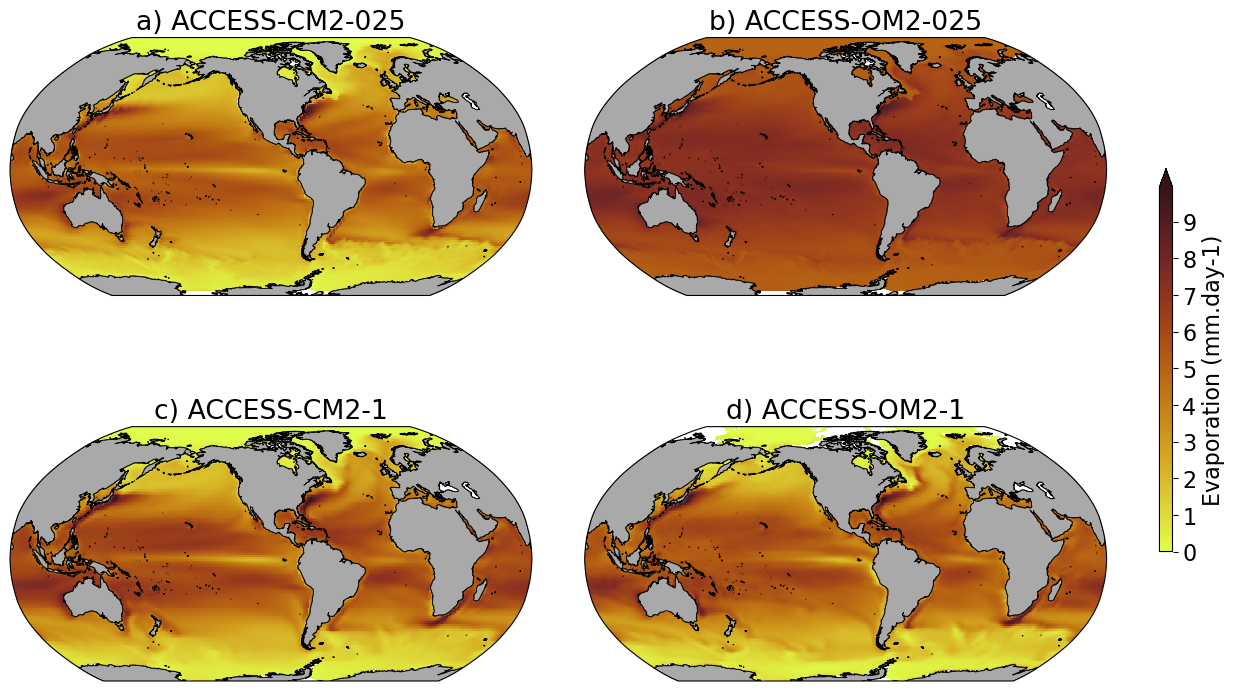

In [17]:
fig = plt.figure(figsize=(15,10))
gs  = gridspec.GridSpec(8, 3, width_ratios=[1, 1, 0.025], hspace=0.05, wspace=0.15)

ax = fig.add_subplot(gs[0:4,0], projection=ccrs.Robinson(central_longitude=-100))
sc = evap_CM2_025_clim_mmd.mean('month').plot(x='geolon_t', y='geolat_t', transform=ccrs.PlateCarree(), cmap=cm.cm.solar_r, add_colorbar=False) 
# sc = evap_CM2_025_clim.mean('month').plot(x='geolon_t', y='geolat_t', transform=ccrs.PlateCarree(), vmin=-1e-4, vmax=0, cmap=cm.cm.solar_r, add_colorbar=False) 
#mld_CM2_025_max.mean('time').plot.contour(x='geolon_t', y='geolat_t', transform=ccrs.PlateCarree(), levels=[3000], colour='y')
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
plt.title('a) ACCESS-CM2-025')

ax = fig.add_subplot(gs[0:4,1], projection=ccrs.Robinson(central_longitude=-100))
evap_OM2_025_clim_mmd.mean('month').plot(x='geolon_t', y='geolat_t', transform=ccrs.PlateCarree(), cmap=cm.cm.solar_r, add_colorbar=False)
# evap_OM2_025_clim.mean('month').plot(x='geolon_t', y='geolat_t', transform=ccrs.PlateCarree(), vmin=-1e-4, vmax=0, cmap=cm.cm.solar_r, add_colorbar=False)
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
plt.title('b) ACCESS-OM2-025')

ax = fig.add_subplot(gs[4:,0], projection=ccrs.Robinson(central_longitude=-100))
evap_CM2_1_clim_mmd.mean('month').plot(x='geolon_t', y='geolat_t', transform=ccrs.PlateCarree(), cmap=cm.cm.solar_r, add_colorbar=False)
# evap_CM2_1_clim.mean('month').plot(x='geolon_t', y='geolat_t', transform=ccrs.PlateCarree(), vmin=-1e-4, vmax=0, cmap=cm.cm.solar_r, add_colorbar=False)
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
plt.title('c) ACCESS-CM2-1')

ax = fig.add_subplot(gs[4:,1], projection=ccrs.Robinson(central_longitude=-100))
evap_OM2_1_clim_mmd.mean('month').plot(x='xt_ocean', y='yt_ocean', transform=ccrs.PlateCarree(), cmap=cm.cm.solar_r, add_colorbar=False)
# evap_OM2_1_clim.mean('month').plot(x='xt_ocean', y='yt_ocean', transform=ccrs.PlateCarree(), vmin=-1e-4, vmax=0, cmap=cm.cm.solar_r, add_colorbar=False)
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
plt.title('d) ACCESS-OM2-1')

cbar_ax = fig.add_subplot(gs[2:6, 2])
units_label = evap_OM2_1_clim_mmd.units
# cbar = plt.colorbar(sc, cax=cbar_ax, ticks=np.arange(-1e-4, 0, 2e-5), label='Mean evaporative mass flux (kgm$^{-3}$*ms$^{-1}$)', extend='min') 
cbar = plt.colorbar(sc, cax=cbar_ax, label='Evaporation ('+units_label+')', extend='max', ticks=np.arange(0,10)) 

# Finished
# save_flag = 1
# if save_flag == 1:
#     fig_name = 'Fig_evap_maps.png'
#     plt.savefig(fig_path + fig_name, dpi=300);

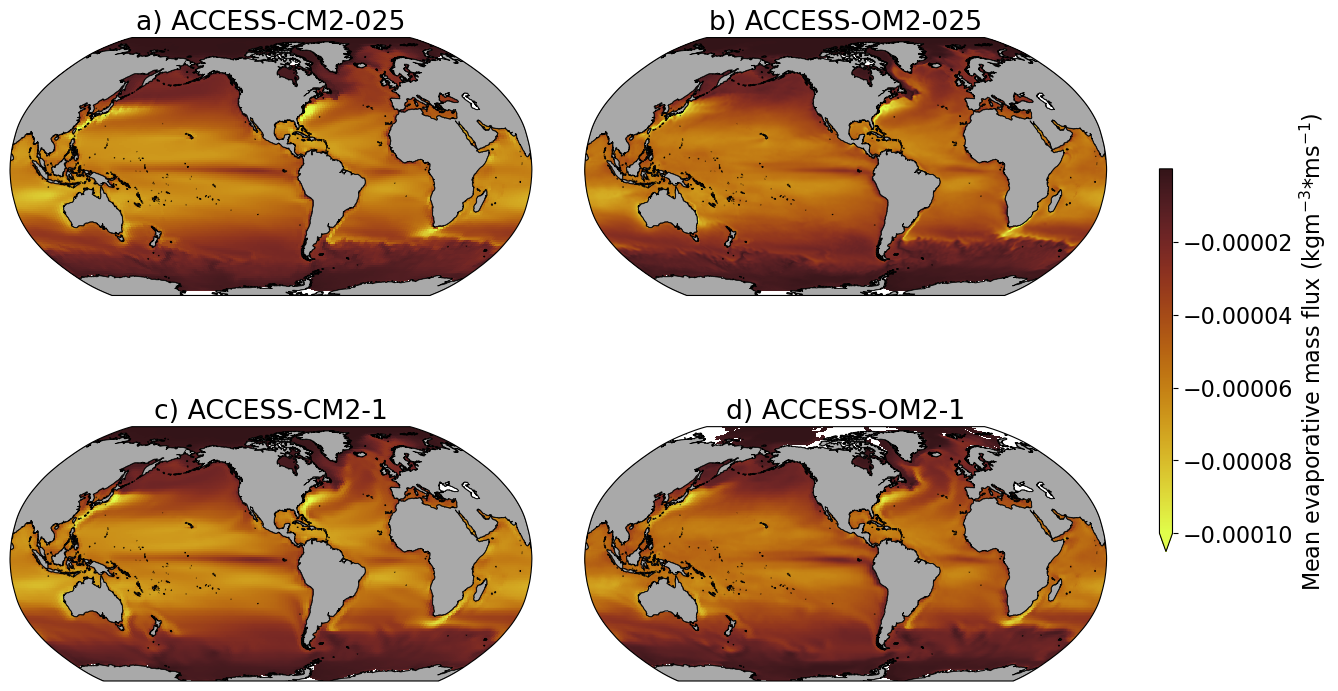